# Lab 9: Generalized Linear Models for Time Series
Welcome to the ninth DS102 lab! 

The goal of this lab is to use generalized linear models to model time series data. In the first part of this lab, we will replicate the example done in [Lecture 22](https://www.data102.org/assets/notes/notes22.pdf) on exponential growth of COVID-19 hospitalizations. In the second part of this lab, we will introduce a new example with continuous data and use a similar technique to model this time series with continuous output. This lab will closely follow the structure of [Discussion 08](https://www.data102.org/assets/disc/disc08/disc08_sol.pdf).

The code you need to write is commented out with a message "TODO: fill in".


## Course Policies

**Collaboration Policy**

Data science is a collaborative activity. While you may talk with others about the labs, we ask that you **write your solutions individually**. If you do discuss the assignments with others please **include their names** by adding a cell below.

**Submission**: to submit this assignment, rerun the notebook from scratch (by selecting Kernel > Restart & Run all), and then print as a pdf (File > download as > pdf) and submit it to Gradescope.


**This assignment should be completed and submitted before Thursday April 9, 2020 at 11:59 PM.**

Write collaborator names here.

In [1]:
import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt
import scipy.stats as sstats
import statsmodels.api as sm
%matplotlib inline

# Time series overview

In this lab, we will be modeling time series using generalized linear models (GLMs). In a time series, we observe some output variable $X_t$, and we want to model the evolution of $X_t$ as time $t$ grows. First, we will observe some examples $X_0,X_1...,X_T$. Our goal is to use our observed data to model $X_t$ as a random variable that depends on $t$, and then potentially predict (or forecast) the values $X_t$ for unobserved $t$ in the future.

# Generalized linear models (GLMs)

So how do we actually model $X_t$ as a random variable that depends on $t$? There are many ways that we could potentially model this, and in most cases we don't know the true relationship between $X_t$ and $t$. However, we can try to *approximate* the relationship between $X_t$ and $t$ using a generalized linear model (GLM). 

[Discussion 08](https://www.data102.org/assets/disc/disc08/disc08_sol.pdf) provides an overview of GLMs. In summary, generalized linear models are a class of models that allow us to specify the relationship between an input variable $T$ and an output variable $X$. Performing regression over GLMs is a generalization of ordinary linear regression. A GLM models $X$ as a distribution that depends on $T$. Specifically, we assume that $T$ is only allowed to directly affect the mean of the distribution of $X$. In other words, the input $T$ only determines the mean $E[X|T]$ of the distribution of $X|T$, and does not affect any other parameters of that distribution (e.g. the variance). 

As for the actual form of the distribution of $X|T$, this where GLMs become a "class" of models: we can actually specify whatever distribution we want for $X|T$, provided that (i) it is an exponential family distribution, and (ii) the above assumption that $T$ only determines the mean $E[X|T]$ holds. Furthermore, the mean $E[X|T]$ needs to be almost a linear function of $T$, but not quite: it needs to be an invertible function $g$ of a linear function of $T$.

Specifically, a generalized linear model has two components that we can specify:

1. **Output distribution**: We need to specify the form of the distribution $X|T$. For example, we could choose 
$$X|T \sim \mathcal{N}(\mu(T), \sigma)$$
where $\mu(T) = E[X|T]$ is a function that depends on $T$, and $\sigma$ is just some fixed variance that we assume we know ahead of time.
2. **Link function**: As stated earlier, the mean $\mu(T) = E[X|T]$ needs to be an invertible function $g$ of a linear function of $T$. That is, there must exist $g$ such that $$g(\mu(T)) = \beta^TT$$
for some parameters $\beta$. 

The generalization of ordinary linear regression boils down to this: in ordinary linear regression, we model $X$ as a **Gaussian distribution** whose mean is a **linear function** of $T$. In a generalized linear model, we can model $X$ as **any other exponential family distribution** whose mean is **any invertible function $g$ of a linear function** of $T$.

Once we've specified the output distribution and link function, the goal is to find the maximum likelihood estimate the linear parameters $\beta$. The nice thing about GLMs is that for this entire class of models, there exist general algorithms for computing the maximum likelihood estimate of $\beta$, for any output distribution or link function that you choose. In this lab, we will use existing libraries for computing the maximum likehood estimate of $\beta$.

Once we have an estimate of the parameters $\beta$, we can use this estimate to predict the values of $X$ for different inputs $T$.


# 1. Discrete time series from Lecture 22
First, we will revisit and implement the example from [Lecture 22](https://www.data102.org/assets/notes/notes22.pdf), where the goal is to predict the number of new hospitalizations from COVID-19 over time.

Let $X_t$ be the observed number of hospitalizations due to COVID-19 on day $t$. $X_t$
is a noisy, random
subset of cases that lead to hospitalizations, so we also include in our model latent variables $Z_t$
representing the true number of cases that should require hospitalization on day $t$. We assume that $X_t$ has mean $Z_t$.

Epidemiology  tells  us  that  in  some  settings, exponential growth for $Z_t$ is reasonable: 

$$Z_{t} = (1+r)Z_{t-1}$$ for some unknown growth rate $r$. 

Unrolling the recursion (done in [Discussion 08](https://www.data102.org/assets/disc/disc08/disc08_sol.pdf)), this is equivalent to 

$$Z_{t} = \exp{(\beta_0 + \beta_1 t)}$$
where $$\beta_0 = \log(Z_0)$$ and $$\beta_1 = \log(1+r).$$

We observe the number of new hospitalizations due to COVID-19 for 14 days (so we observe $X_0,...,X_{14}$). Using this data, we will obtain maximum likelihood estimates of $\beta_0$ and $\beta_1$, which can be translated into estimates of $Z_0$ and $r$. 

## Plot the data
First, we will plot the number of new hospitalizations due to COVID-19 over 14 days that we observed. 

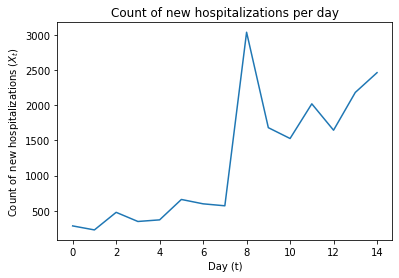

In [2]:
# Plot the number of hospitalizations per day.
# No TODOs here, just run this cell to plot.

# Data for $X_0,...,X_14$
hosps_counts = np.array([285, 228, 478, 348, 371, 661, 599, 571, 3039, 1682, 1528, 2021, 1646, 2183, 2464])
days = np.arange(hosps_counts.size)

plt.title("Count of new hospitalizations per day")
plt.ylabel("Count of new hospitalizations ($X_t$)")
plt.xlabel("Day (t)")
plt.plot(days, hosps_counts)
plt.show()

## A. GLM with Poisson output distribution 

As described in lecture, one reasonable model for the number of hospitalizations per day is
$$X_t \sim Poisson(Z_t).$$

Plugging in our exponential growth assumption of $Z_t$ from earlier, we have 

$$Z_{t} = \exp{(\beta_0 + \beta_1 t)}$$
so 
$$X_t \sim Poisson(\exp{(\beta_0 + \beta_1 t)}).$$

If we estimate $\beta_0$ and $\beta_1$, then we can predict future values of $X_t$ for future values of $t > 14$. 

So how do we estimate $\beta_0$ and $\beta_1$? It turns out that this model of $X_t$ is actually a GLM with input $t$ and output $X_t$. The GLM has
1. **Output distribution**: $X_t \sim Poisson(\mu(t))$ where $\mu(t) = \exp{(\beta_0 + \beta_1 t)}$
2. **Link function**: Setting $g(x) = \log(x)$, we have $g(\mu(t)) = \beta_0 + \beta_1 t$.

Using existing libraries for obtaining the maximum likelihood estimate of $\beta$ for arbitrary GLMs, we can obtain our own estimates for $\beta_0$ and $\beta_1$. Further, these existing libraries can also produce confidence intervals on $\beta$, which we can then use to produce confidence intervals on $X_t$.


In [3]:
# No TODOs here, just understand the steps of this function.
def fit_poisson_GLM(counts, days):
    """Estimates the parameters of the Poisson GLM.
    Fits a model of the form count ~ Poisson(exp(beta0 + beta1 * day)).
    
    Args:
      counts: Observed counts of hospitalizations per day (X_t).
      days: Days corresponding with the observed counts (t).
    
    Returns:
      beta0_MLE: maximum likelihood estimate of beta0.
      beta1_MLE: maximum likelihood estimate of beta1.
      beta1_lower: lower confidence bound on beta1.
      beta1_upper: upper confidence bound on beta1.
    """
    # Output distribution is Poisson. 
    # The link function is g(x) = log(x) by default with the Poisson family.
    glm = sm.GLM(counts, sm.add_constant(days), family=sm.families.Poisson())
    fitted_glm = glm.fit()
    summary = fitted_glm.summary()
    print(summary)
    
    # Get the maximum likelihood estimates of beta0 and beta1.
    beta0_MLE = fitted_glm.params[0]
    beta1_MLE = fitted_glm.params[1]
    
    # Compute the confidence interval on beta_1.
    confint = fitted_glm.conf_int(cols=(1,))[0]
    beta1_lower = confint[0]
    beta1_upper = confint[1]
    return beta0_MLE, beta1_MLE, beta1_lower, beta1_upper

In [4]:
# No TODOs here, just run this cell to estimate the parameters of the Poisson GLM.
beta0_MLE, beta1_MLE, beta1_lower, beta1_upper = fit_poisson_GLM(hosps_counts, days)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                   15
Model:                            GLM   Df Residuals:                       13
Model Family:                 Poisson   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1576.6
Date:                Thu, 09 Apr 2020   Deviance:                       3024.0
Time:                        16:22:45   Pearson chi2:                 3.94e+03
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.8219      0.020    289.361      0.0

### i. Given our estimates of $\beta_0$ and $\beta_1$, we can convert these estimates to estimates of $Z_0$ and $r$.

Recall from the setup that unrolling the recursion $Z_{t} = (1+r)Z_{t-1}$ yields
$$Z_{t} = \exp{(\beta_0 + \beta_1 t)}$$
where $$\beta_0 = \log(Z_0)$$ and $$\beta_1 = \log(1+r).$$

In [5]:
# TODO: convert estimate of beta0 to an estimate of Z0.
def convert_beta0_to_Z0(beta0):
    """Converts beta0 to initial true count Z0."""
    Z0 = 10**beta0 # TODO
    return Z0

Z0_MLE = convert_beta0_to_Z0(beta0_MLE)
print('Estimate of Z0: %s' % Z0_MLE)

Estimate of Z0: 663623.9196689739


In [6]:
# TODO: convert estimate of beta1 to an estimate of Z1.
def convert_beta1_to_r(beta1):
    """Converts beta1 to rate parameter r."""
    r = 10**beta1 - 1# TODO
    return r

r_MLE = convert_beta1_to_r(beta1_MLE)
print('Estimate of r: %s' % r_MLE)

r_lower = convert_beta1_to_r(beta1_lower)
print('Lower confidence bound on r: %s' % r_lower)

r_upper = convert_beta1_to_r(beta1_upper)
print('Upper confidence bound on r: %s' % r_upper)

Estimate of r: 0.42006180677481586
Lower confidence bound on r: 0.4076631291663939
Upper confidence bound on r: 0.4325696917662063


### ii. Using our estimates of $Z_0$ and $r$, we can now calculate estimates of $Z_t$ for any $t$.
To do this, we first need to write $Z_t$ as a function of $Z_0$ and $r$. Recall that $Z_t = (1+r)Z_{t-1}$. Unrolling the recursion, we have 

$$Z_t = Z_0(1+r)^t.$$

In [15]:
# TODO: Using our estimates of Z0 and r, calculate the vector of all Zs.
def calculate_all_Zs(Z0, r, days):
    """Calculates Z_t for all time steps t given Z0 and r.
    
    Args:
      Z0: scalar initial count Z0.
      r: scalar growth rate of counts.
      days: array containing time steps t for which we want to calculate Z_t.
    
    Returns:
      Zs: array with the same length as days, where each entry in Zs is the
        calculated Z_t for the corresponding t in days.
    """
    
    
    Zs = np.array([Z0 * (1+r)**t for t in days]) # TODO
    return Zs

Zs_MLE = calculate_all_Zs(Z0_MLE, r_MLE, days)
Zs_MLE

array([  663623.91966897,   942386.98238411,  1338247.76088544,
        1900394.53323533,  2698677.69445115,  3832289.1226852 ,
        5442087.41564382,  7728100.48808565, 10974380.34204824,
       15584298.37676304, 22130666.91022396, 31426914.83766426,
       44628161.46573178, 63374747.60406528, 89996058.58652687])

### Calculate confidence bounds on $Z_t$ and $X_t$.
The estimated confidence interval on $r$ from the GLM directly translates into a confidence interval on the $Z_t$. For each estimated $Z_t$, we can also calculate a 95% confidence interval on the observed counts $X_t$, which are drawn from a Poisson distribution centered at $Z_t$.

In [16]:
# No TODOs here, just run this cell to calculate confidence bounds.

# Calculate upper and lower confidence bounds on Zs from r.
Zs_lower = calculate_all_Zs(Z0_MLE, r_lower, days)
Zs_upper = calculate_all_Zs(Z0_MLE, r_upper, days)

# Calculate upper and lower confidence bounds on Xs.
Xs_lower = sstats.poisson.ppf(0.025, Zs_lower)
Xs_upper = sstats.poisson.ppf(0.975, Zs_upper)

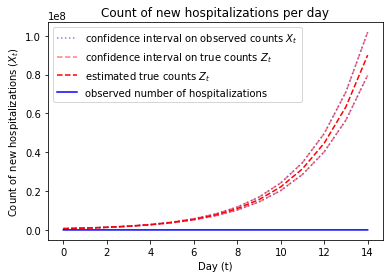

In [17]:
# Plot Zs and Xs. No TODOs here, just run this cell to plot results.

plt.plot(days, Xs_lower, 'b', alpha=0.5, label="confidence interval on observed counts $X_t$", linestyle='dotted')
plt.plot(days, Xs_upper, 'b', alpha=0.5, linestyle='dotted')

plt.plot(days, Zs_lower, 'r', alpha=0.5, label="confidence interval on true counts $Z_t$", linestyle='dashed')
plt.plot(days, Zs_MLE, 'r', label="estimated true counts $Z_t$", linestyle='dashed')
plt.plot(days, Zs_upper, 'r', alpha=0.5, linestyle='dashed')

plt.plot(days, hosps_counts, 'b', label="observed number of hospitalizations")
plt.title("Count of new hospitalizations per day")
plt.ylabel("Count of new hospitalizations ($X_t$)")
plt.xlabel("Day (t)")
plt.legend()

## B. GLM with Negative Binomial output distribution

In addition to the Poisson distribution, another natural model for count data is the Negative Binomial distribution. The Negative Binomial distribution has a second parameter called the dispersion parameter which allows it to model greater spread/variance relative to a Poisson distribution with the same mean. This will allow our confidence bounds on $X_t$ to better capture the spread of the observed data than the Poisson model.

We will keep the same exponential growth of $Z_t$, but we will instead model $X_t$ as 

$$X_t \sim NBinom(Z_t, \alpha),$$

where $Z_t$ is the mean of the Negative Binomial distribution, and we fix $\alpha=0.15$ as the dispersion parameter.

Again plugging in our exponential growth assumption of $Z_t$ from earlier, we have 

$$Z_{t} = \exp{(\beta_0 + \beta_1 t)}$$
so 
$$X_t \sim NBinom(\exp{(\beta_0 + \beta_1 t)}).$$

This model of $X_t$ is again a GLM with input $t$ and output $X_t$. The GLM has
1. **Output distribution**: $X_t \sim NBinom(\mu(t))$ where $\mu(t) = \exp{(\beta_0 + \beta_1 t)}$
2. **Link function**: Setting $g(x) = \log(x)$, we have $g(\mu(t)) = \beta_0 + \beta_1 t$.



In [18]:
# No TODOs here, just understand the steps of this function.
def fit_nbinom_GLM(counts, days, alpha=0.15):
    """Estimates the parameters of the Poisson GLM.
    Fits a model of the form count ~ NBinom(exp(beta0 + beta1 * day), alpha).
    
    Args:
      counts: Observed counts of hospitalizations per day (X_t).
      days: Days corresponding with the observed counts (t).
      alpha: dispersion paramter for the negative binomial. 
        We fix this to 0.15 by default for this example.
    
    Returns:
      beta0_MLE: maximum likelihood estimate of beta0.
      beta1_MLE: maximum likelihood estimate of beta1.
      beta1_lower: lower confidence bound on beta1.
      beta1_upper: upper confidence bound on beta1.
    """
    # Output distribution is NegativeBinomial. 
    # The link function is g(x) = log(x) by default with the NegativeBinomial family.
    glm = sm.GLM(counts, sm.add_constant(days), family=sm.families.NegativeBinomial(alpha=alpha))
    fitted_glm = glm.fit()
    summary = fitted_glm.summary()
    print(summary)
    
    # Get the maximum likelihood estimates of beta0 and beta1.
    beta0_MLE = fitted_glm.params[0]
    beta1_MLE = fitted_glm.params[1]
    
    # Compute the confidence interval on beta_1.
    confint = fitted_glm.conf_int(cols=(1,))[0]
    beta1_lower = confint[0]
    beta1_upper = confint[1]
    return beta0_MLE, beta1_MLE, beta1_lower, beta1_upper

In [19]:
# No TODOs here, just run this cell to estimate the parameters of the Poisson GLM.
beta0_MLE, beta1_MLE, beta1_lower, beta1_upper = fit_nbinom_GLM(hosps_counts, days)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                   15
Model:                            GLM   Df Residuals:                       13
Model Family:        NegativeBinomial   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -109.15
Date:                Thu, 09 Apr 2020   Deviance:                       15.552
Time:                        16:28:33   Pearson chi2:                     24.2
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.5938      0.192     29.140      0.0

### Given our estimates of $\beta_0$ and $\beta_1$, we can convert these estimates to estimates of $Z_0$ and $r$.

In [20]:
# No TODOs here, we can reuse the same functions we wrote in part A for this conversion.
Z0_MLE = convert_beta0_to_Z0(beta0_MLE)
print('Estimate of Z0: %s' % Z0_MLE)

Estimate of Z0: 392460.3898279551


In [21]:
# No TODOs here, we can reuse the same functions we wrote in part A for this conversion.
r_MLE = convert_beta1_to_r(beta1_MLE)
print('Estimate of r: %s' % r_MLE)

r_lower = convert_beta1_to_r(beta1_lower)
print('Lower confidence bound on r: %s' % r_lower)

r_upper = convert_beta1_to_r(beta1_upper)
print('Upper confidence bound on r: %s' % r_upper)

Estimate of r: 0.5109418550205693
Lower confidence bound on r: 0.36028212226921763
Upper confidence bound on r: 0.6782880932409803


### Using our estimates of $Z_0$ and $r$, we can now calculate estimates of $Z_t$ for any $t$.
As in part A, we have the same  $Z_t = Z_0(1+r)^t.$

In [22]:
# No TODOs here, we can reuse the same functions we wrote in part A.
Zs_MLE = calculate_all_Zs(Z0_MLE, r_MLE, days)

### Calculate confidence bounds on $Z_t$ and $X_t$.
The estimated confidence interval on $r$ from the GLM directly translates into a confidence interval on the $Z_t$. For each estimated $Z_t$, we can also calculate a 95% confidence interval on the observed counts $X_t$, which are drawn from a Poisson distribution centered at $Z_t$.

In [23]:
# No TODOs here, just run this cell to calculate confidence bounds.

# Calculate upper and lower confidence bounds on Zs from r.
Zs_lower = calculate_all_Zs(Z0_MLE, r_lower, days)
Zs_upper = calculate_all_Zs(Z0_MLE, r_upper, days)

# Calculate upper and lower confidence bounds on Xs.
# These functions convert the mean Z and dispersion alpha parameter into 
# the n and p paramters under a different parameterization of the 
# negative binomial distribution family. 
alpha = 0.15
def n():
    return 1.0/alpha
def p(mu):
    return n() / (n() + mu)
Xs_lower = sstats.nbinom.ppf(0.025, n(), p(Zs_lower))
Xs_upper = sstats.nbinom.ppf(0.975, n(), p(Zs_upper))

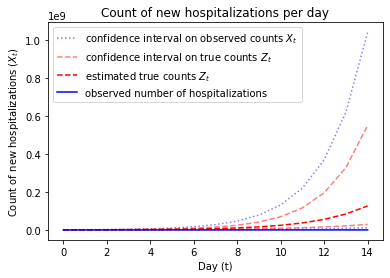

In [24]:
# Plot Zs and Xs. No TODOs here, just run this cell to plot results.

plt.plot(days, Xs_lower, 'b', alpha=0.5, label="confidence interval on observed counts $X_t$", linestyle='dotted')
plt.plot(days, Xs_upper, 'b', alpha=0.5, linestyle='dotted')

plt.plot(days, Zs_lower, 'r', alpha=0.5, label="confidence interval on true counts $Z_t$", linestyle='dashed')
plt.plot(days, Zs_MLE, 'r', label="estimated true counts $Z_t$", linestyle='dashed')
plt.plot(days, Zs_upper, 'r', alpha=0.5, linestyle='dashed')

plt.plot(days, hosps_counts, 'b', label="observed number of hospitalizations")
plt.title("Count of new hospitalizations per day")
plt.ylabel("Count of new hospitalizations ($X_t$)")
plt.xlabel("Day (t)")
plt.legend()

### i. Question: Which of the two GLM models did a better job of estimating the confidence interval of the observed counts $X_t$? Which of the two GLM models projects higher possible counts of new hospitalizations in the future (according to the upper confidence bound)?

GLM with poisson output distribution did a better job at estimating the CI by having a much tighter bound around the true value. GLM with negative binomaial output distribution projects a higher possible count of new hospitalizations in the future. 

# 2. Continuous time series 
In the previous example from Lecture 22, our time series was discrete: the observations $X_t$ were all positive integers representing the counts of hospitalizations per day. In the rest of this lab, we will demonstrate that GLMs can be used to model time series with continuous observations as well. 

Suppose a rocket has been launched in Florida, and we in California start observing the rocket at time $t=0$. We want to measure the rocket's distance from Earth at some time $t$ in the future. At each time step, we obtain a noisy measurement of this distance.

Let $X_t$ denote our observation of the rocket's distance from Earth (in kilometers) at time $t$ (seconds), which is noisy due to weather, measurement error, etc. Let $Z_t$ be the rocket's true distance from Earth at time $t$. We assume that $X_t$ has mean $Z_t$.

Let $r$ be the rate at which the rocket is moving away from Earth in kilometers per second (we assume that the rocket is moving at a constant rate). Then $Z_t$ grows as:

$$Z_t = Z_{t-1} + r$$

As done in part 1, unrolling the recursion, we have that 

$$Z_t = \beta_0 + \beta_1t$$

where 

$$\beta_0 = Z_0$$ 

and 

$$\beta_1 = r.$$

We obtain noisy observations the rocket's distance from Earth for 20 seconds (so we observe $X_0,...,X_{20}$). Using this data, we will obtain maximum likelihood estimates of $\beta_0$ and $\beta_1$, which can be translated into estimates of $Z_0$ and $r$. 

## Plot the data
First, we will plot the rocket's distance from Earth over the 20 seconds that we observed.

We will simulate the observed data. In the simulated data, for all $t$ our observation noise will be normally distributed with a standard deviation of $\sigma = 15$ kilometers. The true starting point $Z_0$ for the simulation will be $100$ kilmeters away from Earth, and the true $r$ will be $7.9$ kilometers per second.



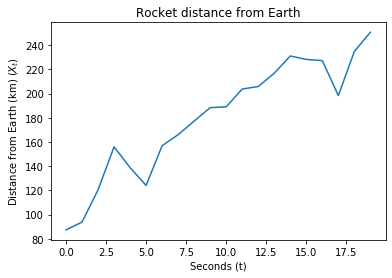

In [25]:
# Plot the rocket's distance.
true_r = 7.9
true_Z0 = 100

seconds = np.arange(20)
true_dists = true_Z0 + true_r * seconds

sigma = 15
noise = np.random.normal(0, sigma, len(seconds))

# Data for $X_0,...,X_12$
obs_dists = true_dists + noise

plt.title("Rocket distance from Earth")
plt.ylabel("Distance from Earth (km) ($X_t$)")
plt.xlabel("Seconds (t)")
plt.plot(seconds, obs_dists)
plt.show()

## A. GLM with Gaussian output distribution
As actual observers, we don't know how the simulated data was generated: we don't know the true position when we started observing ($Z_0$), and we don't know the true speed of the rocket $r$. However, suppose we do know that our observations have normally distributed noise with a known standard deviation $\sigma = 15$ kilometers. Then we would model $X_t$ as 

$$X_t \sim Normal(Z_t, \sigma).$$

Plugging in the growth of $Z_t$ from earlier, we have

$$X_t \sim Normal(\beta_0 + \beta_1t, \sigma).$$

This model of $X_t$ is a GLM with input $t$ and output $X_t$. The GLM has
1. **Output distribution**: $X_t \sim Normal(\mu(t))$ where $\mu(t) = \beta_0 + \beta_1t$
2. **Link function**: Setting $g(x) = x$, we have $g(\mu(t)) = \beta_0 + \beta_1 t$.

Our goal is to estimate $\beta_0$ and $\beta_1$ from observations $X_0,X_1,...,X_{20}$.

This setup likely looks familiar: it turns out that estimating the parameters $\beta_0$ and $\beta_1$ for this GLM is exactly the same as ordinary linear regression. In fact, the ordinary least squares estimate is exactly the MLE for $\beta_0$ and $\beta_1$. However, for this exercise we will use the GLM libraries to produce our estimates.

In [26]:
# No TODOs here, just understand the steps of this function.
def fit_gaussian_GLM(dists, seconds, sigma=15.):
    """Estimates the parameters of the Gaussian GLM.
    Fits a model of the form count ~ Normal(beta0 + beta1 * second, sigma).
    
    Args:
      dists: Observed distances of the rocket per second (X_t).
      seconds: seconds corresponding with the observed counts (t).
    
    Returns:
      beta0_MLE: maximum likelihood estimate of beta0.
      beta1_MLE: maximum likelihood estimate of beta1.
      beta1_lower: lower confidence bound on beta1.
      beta1_upper: upper confidence bound on beta1.
    """
    # Output distribution is Gaussian. 
    # The link function is g(x) = x by default with the Gaussian family.
    glm = sm.GLM(dists, sm.add_constant(seconds), family=sm.families.Gaussian())
    fitted_glm = glm.fit(scale=sigma**2)
    summary = fitted_glm.summary()
    print(summary)
    
    # Get the maximum likelihood estimates of beta0 and beta1.
    beta0_MLE = fitted_glm.params[0]
    beta1_MLE = fitted_glm.params[1]
    
    # Compute the confidence interval on beta_1.
    confint = fitted_glm.conf_int(cols=(1,))[0]
    beta1_lower = confint[0]
    beta1_upper = confint[1]
    print(np.sqrt(fitted_glm.scale))
    return beta0_MLE, beta1_MLE, beta1_lower, beta1_upper

In [27]:
# No TODOs here, just run this cell to estimate the parameters of the Poisson GLM.
beta0_MLE, beta1_MLE, beta1_lower, beta1_upper = fit_gaussian_GLM(obs_dists, seconds)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                   20
Model:                            GLM   Df Residuals:                       18
Model Family:                Gaussian   Df Model:                            1
Link Function:               identity   Scale:                          225.00
Method:                          IRLS   Log-Likelihood:                -82.559
Date:                Thu, 09 Apr 2020   Deviance:                       4508.6
Time:                        16:31:59   Pearson chi2:                 4.51e+03
No. Iterations:                     2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        106.6051      6.464     16.492      0.0

### i. Given our estimates of $\beta_0$ and $\beta_1$, we can convert these estimates to estimates of $Z_0$ and $r$.
Recall in the setup that $Z_t = Z_{t-1} + r$. Unrolling the recursion, we have 

$$Z_t = \beta_0 + \beta_1t$$
where 
$$\beta_0 = Z_0$$ 
and 
$$\beta_1 = r.$$

In [28]:
# TODO: convert estimate of beta0 to an estimate of Z0.
def convert_beta0_to_Z0_gaussian(beta0):
    """Converts beta0 to initial true count Z0."""
    Z0 = beta0 # TODO
    return Z0

Z0_MLE = convert_beta0_to_Z0_gaussian(beta0_MLE)
print('Estimate of Z0: %s' % Z0_MLE)

Estimate of Z0: 106.60510306718936


In [29]:
# TODO: convert estimate of beta1 to an estimate of Z1.
def convert_beta1_to_r_gaussian(beta1):
    """Converts beta1 to rate parameter r."""
    r = beta1# TODO
    return r

r_MLE = convert_beta1_to_r_gaussian(beta1_MLE)
print('Estimate of r: %s' % r_MLE)

r_lower = convert_beta1_to_r_gaussian(beta1_lower)
print('Lower confidence bound on r: %s' % r_lower)

r_upper = convert_beta1_to_r_gaussian(beta1_upper)
print('Upper confidence bound on r: %s' % r_upper)

Estimate of r: 7.695380017948468
Lower confidence bound on r: 6.555317867778622
Upper confidence bound on r: 8.835442168118313


### ii. Using our estimates of $Z_0$ and $r$, we can now calculate estimates of $Z_t$ for any $t$.
To do this, we first need to write $Z_t$ as a function of $Z_0$ and $r$. Recall that $Z_t = Z_{t-1} + r$. Unrolling the recursion, we have 

$$Z_t = Z_0 + rt.$$

In [30]:
# TODO: Using our estimates of Z0 and r, calculate the vector of all Zs.
def calculate_all_Zs_gaussian(Z0, r, seconds):
    """Calculates Z_t for all time steps t given Z0 and r.
    
    Args:
      Z0: scalar initial count Z0.
      r: scalar growth rate of counts.
      days: array containing time steps t for which we want to calculate Z_t.
    
    Returns:
      Zs: array with the same length as days, where each entry in Zs is the
        calculated Z_t for the corresponding t in days.
    """
    Zs = np.array([Z0 + r*t for t in seconds])# TODO
    return Zs

Zs_MLE = calculate_all_Zs_gaussian(Z0_MLE, r_MLE, seconds)

### Calculate confidence bounds on $Z_t$ and $X_t$.
The estimated confidence interval on $r$ from the GLM directly translates into a confidence interval on the $Z_t$. For each estimated $Z_t$, we can also calculate a 95% confidence interval on the observed counts $X_t$, which are drawn from a Normal distribution centered at $Z_t$ with standard deviation $\sigma = 15$.

In [31]:
# No TODOs here, just run this cell to calculate confidence bounds.

# Calculate upper and lower confidence bounds on Zs from r.
Zs_lower = calculate_all_Zs_gaussian(Z0_MLE, r_lower, seconds)
Zs_upper = calculate_all_Zs_gaussian(Z0_MLE, r_upper, seconds)

# Calculate upper and lower confidence bounds on Xs.
sigma = 15
Xs_lower = sstats.norm.ppf(0.025, Zs_lower, scale=sigma)
Xs_upper = sstats.norm.ppf(0.975, Zs_upper, scale=sigma)

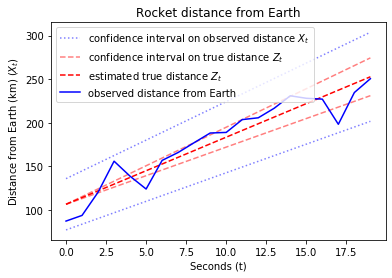

In [32]:
# Plot Zs and Xs. No TODOs here, just run this cell to plot results.

plt.plot(seconds, Xs_lower, 'b', alpha=0.5, label="confidence interval on observed distance $X_t$", linestyle='dotted')
plt.plot(seconds, Xs_upper, 'b', alpha=0.5, linestyle='dotted')

plt.plot(seconds, Zs_lower, 'r', alpha=0.5, label="confidence interval on true distance $Z_t$", linestyle='dashed')
plt.plot(seconds, Zs_MLE, 'r', label="estimated true distance $Z_t$", linestyle='dashed')
plt.plot(seconds, Zs_upper, 'r', alpha=0.5, linestyle='dashed')

plt.plot(seconds, obs_dists, 'b', label="observed distance from Earth")
plt.title("Rocket distance from Earth")
plt.ylabel("Distance from Earth (km) ($X_t$)")
plt.xlabel("Seconds (t)")
plt.legend()
plt.show()